In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import matplotlib.colors as colors

from nanonets.utils import fft, harmonic_strength, total_harmonic_distortion, sinusoidal_voltages
from scipy import signal

plt.style.use(["science","bright","grid"])
PATH = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/freq_manipulation_two_tone/"
# PATH = "/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/AC/freq_manipulation/"

/home/jonasmensing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [8]:
N_NP            = 9
STAT_SIZE_BASE  = 10
N_PERIODS       = 100
N_SAMPLES       = 1280
SAMPLE_P_PERIOD = 40
F0              = 28.0
F1              = 55.0
AMPLITUDE       = 0.02
U_BOUNDS        = 0.05
CPU_CNT         = 32
N_EQ_PERIODS    = 20

topo    = {"Nx": N_NP,"Ny": N_NP,
               "e_pos": [[(N_NP-1)//2, 0],
                         [0, 0],
                         [N_NP-1, 0],
                         [0, (N_NP-1)//2],
                         [N_NP-1, (N_NP-1)//2],
                         [0, N_NP-1],
                         [N_NP-1, N_NP-1],
                         [(N_NP-1)//2, N_NP-1]],
                "electrode_type": ['constant']*8}

# Generate base waveform
f0_hz       = F0 * 1e6
f1_hz       = F1 * 1e6
dt          = 1 / (SAMPLE_P_PERIOD * f1_hz)
T_sim       = N_PERIODS / f1_hz
N_steps     = int(np.ceil(T_sim / dt))
stat_size   = max(STAT_SIZE_BASE, int(np.round(300*F1/5.0)))


time_steps, base_volt = sinusoidal_voltages(
    N_steps, topo,
    amplitudes=[0.,AMPLITUDE,AMPLITUDE,0.,0.,0.,0.,0.],
    frequencies=[0.,f0_hz,f1_hz,0.,0.,0.,0.,0.],
    time_step=dt
)
t  = time_steps[:-N_EQ_PERIODS*SAMPLE_P_PERIOD-1]*1e9
x1 = base_volt[N_EQ_PERIODS*SAMPLE_P_PERIOD:-1,:][:,1]*1000
x2 = base_volt[N_EQ_PERIODS*SAMPLE_P_PERIOD:-1,:][:,2]*1000

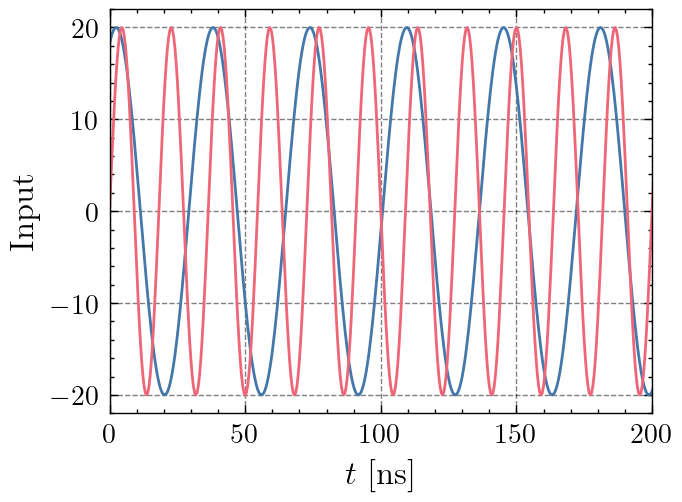

In [13]:
fig, ax = plt.subplots(dpi=200)
ax.plot(t, x1)
ax.plot(t, x2)
ax.set_ylabel("Input", fontsize='large')
ax.set_xlabel("$t$ [ns]", fontsize='large')
ax.set_xlim(0,200)
fig.savefig("plots/two_tone_manipulation/input_signal.svg", transparent=True)

In [5]:
data = {}
for i in range(N_SAMPLES):
    try:
        df = pd.read_csv(f"{PATH}Nx=9_Ny=9_Ne=8_{i}.csv")
        df = df.iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)['Observable'].values*1e-9
        data[i] = df
    except:
        pass

In [14]:
def intermodulation_strength(
    signal: np.ndarray, 
    f0: float, 
    f1: float, 
    dt: float, 
    mixing_products,
    use_hann: bool = False, 
    n_padded: int = 0, 
    amplitude_threshold: float = 1e-3
) -> np.ndarray:
    """
    Compute the relative amplitudes of selected frequency mixing products 
    (m*f0 + n*f1) of a signal driven by two fundamental frequencies f0 and f1.

    Parameters
    ----------
    signal : np.ndarray
        Input time-domain signal.
    f0 : float
        First fundamental frequency (Hz).
    f1 : float
        Second fundamental frequency (Hz).
    dt : float
        Sampling interval (seconds).
    mixing_products : List[Tuple[int, int]]
        A list of (m, n) integer tuples defining the target mixing frequencies 
        f_target = abs(m*f0 + n*f1). E.g., for 2*f1 - f0, use (-1, 2).
    use_hann : bool, optional
        If True, apply a Hann window before FFT.
    n_padded : int, optional
        Length to zero-pad signal to before FFT.
    amplitude_threshold : float, optional
        Minimum reference amplitude (max(A_f0, A_f1)) to compute relative 
        amplitudes.

    Returns
    -------
    im_strength : np.ndarray
        Relative amplitudes of the mixing products, normalized to the 
        larger fundamental amplitude: A_(m,n) / max(A_f0, A_f1).
    """
    if not mixing_products:
        return np.array([])
        
    x = np.asarray(signal, dtype=float)
    x = x - np.mean(x) # Remove DC

    # Compute spectrum
    freqs, amps = fft(x, dt, n_padded=n_padded, use_hann=use_hann)
    fs = 1.0 / dt
    nyquist = fs / 2.0

    # 1. Find the amplitudes of the two fundamentals (A_f0 and A_f1)
    idx0 = np.argmin(np.abs(freqs - f0))
    Af0 = amps[idx0]
    
    idx1 = np.argmin(np.abs(freqs - f1))
    Af1 = amps[idx1]
    
    # Reference amplitude for normalization (A_ref = max(A_f0, A_f1))
    A_ref = np.max([Af0, Af1])

    if A_ref < amplitude_threshold:
        # Avoid division by zero/very small numbers
        return np.zeros(len(mixing_products))

    # 2. Calculate and find the amplitude of each mixing product
    im_strength = np.empty(len(mixing_products), dtype=float)

    for i, (m, n) in enumerate(mixing_products):
        # Target frequency is the absolute value of the linear combination
        f_target = np.abs(m * f0 + n * f1)
        
        if f_target > nyquist:
            # Frequency is above Nyquist limit
            im_strength[i] = 0.0
            continue
        
        # Find the closest frequency bin
        idx = np.argmin(np.abs(freqs - f_target))
        
        # Calculate relative strength
        im_strength[i] = amps[idx] / A_ref

    return im_strength

def total_intermodulation_distortion(
    signal: np.ndarray, 
    f0: float, 
    f1: float, 
    dt: float,
    mixing_products,
    use_hann: bool = False, 
    n_padded: int = 0, 
    dB: bool = False
) -> float:
    """
    Compute the Total Intermodulation Distortion (TID) of a signal, based on the
    amplitudes of selected mixing products (m*f0 + n*f1).

    The TID ratio is computed as:
        TID_ratio = sqrt(sum_{m,n} (A_(m,n) / A_ref)^2)
    where A_ref = max(A_f0, A_f1) is the larger fundamental amplitude.

    Parameters
    ----------
    signal : np.ndarray
        Input time-domain signal.
    f0 : float
        First fundamental frequency (Hz).
    f1 : float
        Second fundamental frequency (Hz).
    dt : float
        Sampling interval (seconds).
    mixing_products : List[Tuple[int, int]]
        A list of (m, n) integer tuples defining the target mixing frequencies.
    use_hann : bool, optional
        If True, apply a Hann window before FFT.
    n_padded : int, optional
        Length to zero-pad signal to before FFT.
    dB : bool, optional
        If True, return TID in decibels: 20 * log10(ratio).
        Otherwise, return TID in percent: 100 * ratio.

    Returns
    -------
    tid_value : float
        Total Intermodulation Distortion in percent or decibels.
    """
    # Get normalized intermodulation strengths
    im_s = intermodulation_strength(signal, f0, f1, dt, mixing_products, 
                                    use_hann=use_hann, n_padded=n_padded)
    
    # Calculate the total ratio
    ratio = np.sqrt(np.sum(im_s**2))

    # Output
    if dB:
        if ratio < 1e-12:
            return -np.inf
        return 20.0 * np.log10(ratio)
    else:
        return ratio * 100.0

In [34]:
i_strength = []
for key in data.keys():
    arr = data[key].copy()
    i_strength.append(np.sum(intermodulation_strength(arr, f0_hz, f1_hz, dt, [[1,1],[-1,1],[-1,2],[2,-1],[2,0],[0,2]])))

In [47]:
i_max = list(data.keys())[np.argmax(i_strength)]
i_min = list(data.keys())[np.argmin(i_strength)]
arr_min = data[i_min]
arr_max = data[i_max]

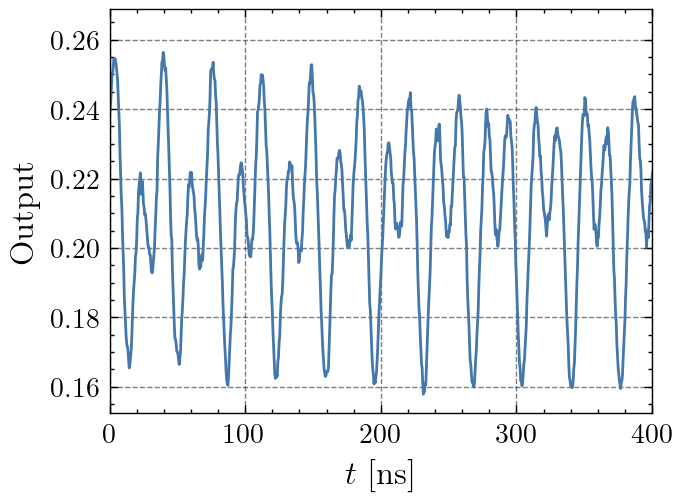

In [54]:
fig, ax = plt.subplots(dpi=200)
ax.plot(t, arr_min)
ax.set_ylabel("Output", fontsize='large')
ax.set_xlabel("$t$ [ns]", fontsize='large')
ax.set_xlim(0,400)
fig.savefig("plots/two_tone_manipulation/output_min.svg", transparent=True)

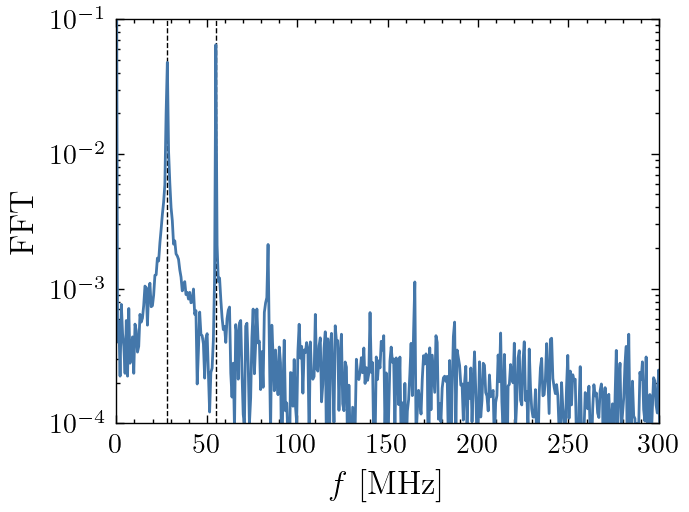

In [74]:
fig, ax = plt.subplots(dpi=200)
xf, yf  = fft(arr_min, dt)
ax.vlines(F0, 1e-4, 1e1, color='black', ls='--', lw=.5)
ax.vlines(F1, 1e-4, 1e1, color='black', ls='--', lw=.5)
ax.plot(xf*1e-6, yf/np.max(yf))

ax.set_ylabel("FFT", fontsize='large')
ax.set_xlabel("$f$ [MHz]", fontsize='large')
ax.set_xlim(0,300)
ax.set_ylim(1e-4,1e-1)
ax.set_yscale('log')
ax.grid(False)
fig.savefig("plots/two_tone_manipulation/fft_min.svg", transparent=True)

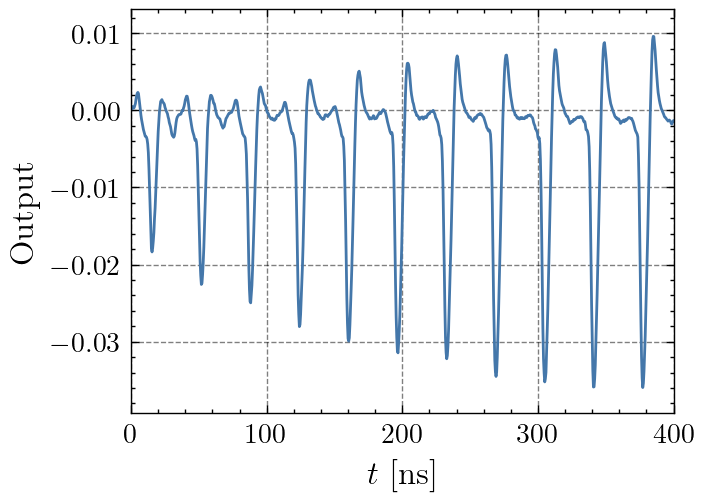

In [55]:
fig, ax = plt.subplots(dpi=200)
ax.plot(t, arr_max)
ax.set_ylabel("Output", fontsize='large')
ax.set_xlabel("$t$ [ns]", fontsize='large')
ax.set_xlim(0,400)
fig.savefig("plots/two_tone_manipulation/output_max.svg", transparent=True)

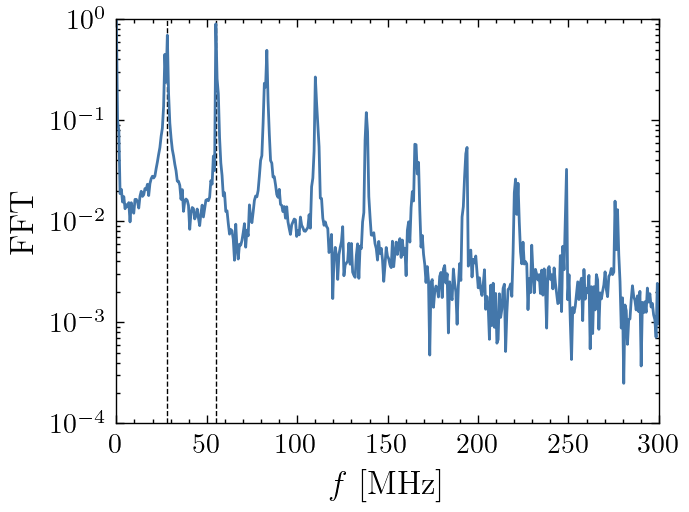

In [78]:
fig, ax = plt.subplots(dpi=200)
xf, yf  = fft(arr_max, dt)
ax.vlines(F0, 1e-4, 1e0, color='black', ls='--', lw=.5)
ax.vlines(F1, 1e-4, 1e0, color='black', ls='--', lw=.5)
ax.plot(xf*1e-6, yf/np.max(yf))

ax.set_ylabel("FFT", fontsize='large')
ax.set_xlabel("$f$ [MHz]", fontsize='large')
ax.set_xlim(0,300)
ax.set_ylim(1e-4,1e0)
ax.set_yscale('log')
ax.grid(False)
fig.savefig("plots/two_tone_manipulation/fft_max.svg", transparent=True)

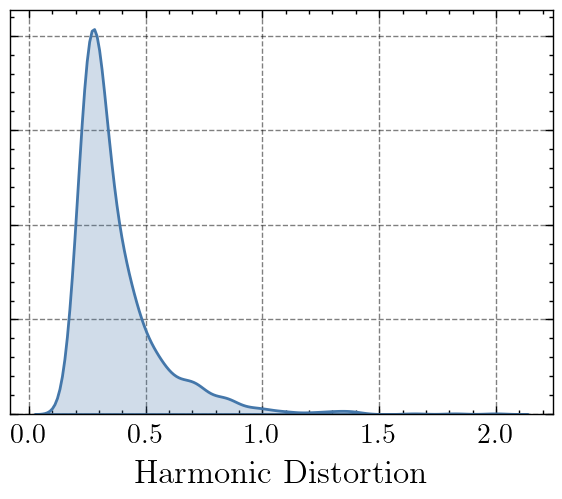

In [56]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.kdeplot(i_strength, fill=True)
ax.set_xlabel("Harmonic Distortion", fontsize='large')
ax.set_ylabel("")
_ = ax.set_yticklabels("")

fig.savefig("plots/two_tone_manipulation/intermodul_strength.svg", transparent=True)

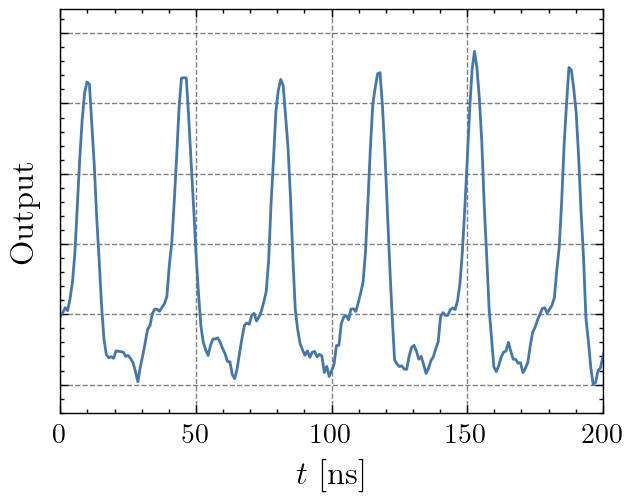

In [303]:
fig, ax = plt.subplots(dpi=200)
ax.plot(t, data_new[np.argmax(thd_vals)])
ax.set_ylabel("Output", fontsize='large')
ax.set_xlabel("$t$ [ns]", fontsize='large')
_ = ax.set_yticklabels("")
ax.set_xlim(0,200)
fig.savefig("plots/freq_manipulation/output_signal_max_thd.svg", transparent=True)

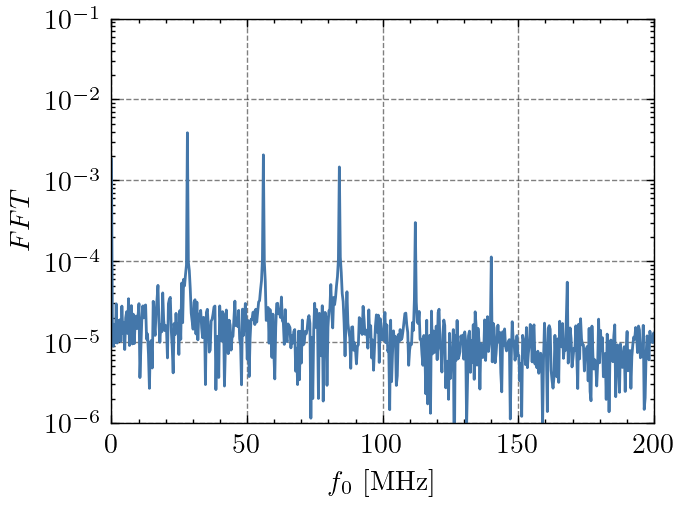

In [295]:
xf2, yf2 = fft(data_new[np.argmax(thd_vals)], dt)
xf2      = xf2 * 1e-6

fig, ax = plt.subplots(dpi=200)
ax.plot(xf2, yf2)
ax.set_ylabel("$FFT$")
ax.set_xlabel("$f_0$ [MHz]")
ax.set_xlim(0,200)
ax.set_ylim(1e-6,1e-1)
ax.set_yscale('log')

(0.0, 200.0)

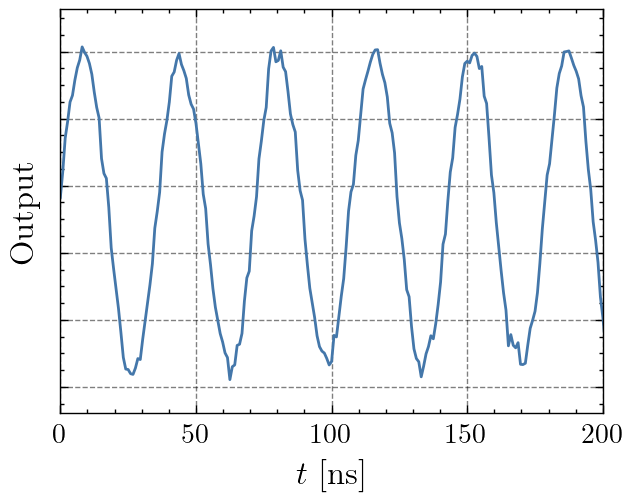

In [ ]:
fig, ax = plt.subplots(dpi=200)
ax.plot(t, data_new[np.argmin(thd_vals)])
ax.set_ylabel("Output", fontsize='large')
ax.set_xlabel("$t$ [ns]", fontsize='large')
_ = ax.set_yticklabels("")
ax.set_xlim(0,200)

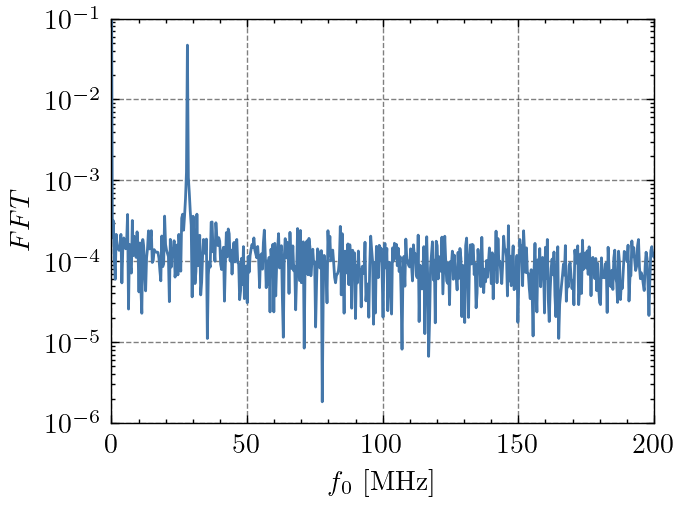

In [296]:
xf2, yf2 = fft(data_new[np.argmin(thd_vals)], dt)
xf2      = xf2 * 1e-6

fig, ax = plt.subplots(dpi=200)
ax.plot(xf2, yf2)
ax.set_ylabel("$FFT$")
ax.set_xlabel("$f_0$ [MHz]")
ax.set_xlim(0,200)
ax.set_ylim(1e-6,1e-1)
ax.set_yscale('log')

(0.0, 120.0)

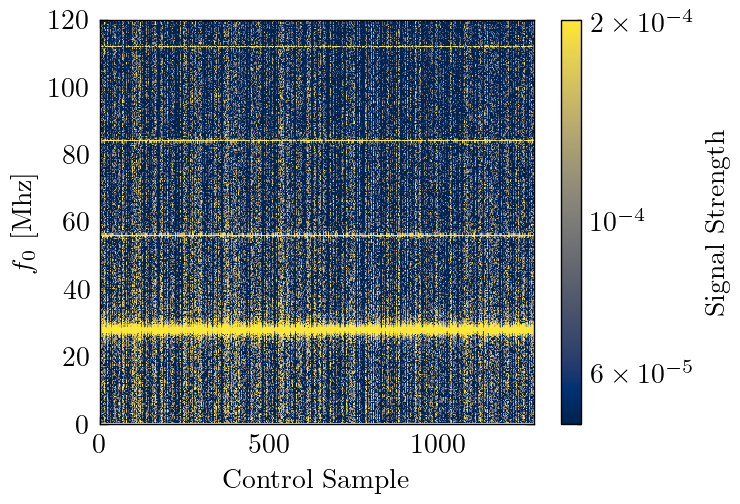

In [ ]:
fft_data = [fft(data_new[i], dt) for i in range(N_SAMPLES)]
xf_wf    = fft_data[0][0] * 1e-6
z_data   = np.array([yf for xf, yf in fft_data])

fig, ax = plt.subplots(dpi=200)
im = ax.pcolormesh(
    range(len(fft_data)),
    xf_wf,
    z_data.T,
    norm=colors.LogNorm(vmin=1e-5, vmax=1e-2),
    cmap='cividis'
)

# Add a color bar to show the mapping of colors to signal strength
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Signal Strength')

# Set the labels and title for clarity
ax.set_xlabel('Control Sample')
ax.set_ylabel('$f_0$ [Mhz]')

# Optional: Set the y-axis limit to focus on a specific frequency range
ax.set_ylim(0, 120)
fig.savefig("plots/freq_manipulation/waterfall_plot.svg", transparent=True)

In [298]:
def normalize_signal(s):
    """Removes DC offset and scales to [-1, 1]."""
    s_no_dc = s - np.mean(s)
    max_val = np.max(np.abs(s_no_dc))
    if max_val == 0:
        return s_no_dc
    return s_no_dc / max_val

def align_and_compare(s, ref):
    """Aligns signal 's' to reference 'ref' and returns the aligned signal and its MSE."""
    # Normalize both signals first for accurate correlation
    s_norm = normalize_signal(s)
    ref_norm = normalize_signal(ref)

    # Compute cross-correlation
    correlation = signal.correlate(s_norm, ref_norm, mode='full')
    # Find the delay (lag) that maximizes the correlation
    lag = np.argmax(correlation) - (len(ref_norm) - 1)

    # Roll the signal to align it with the reference
    s_aligned = np.roll(s_norm, -lag)

    # Calculate MSE on the aligned signal
    mse = np.mean((s_aligned - ref_norm)**2)
    return s_aligned, mse

cosine_curve  = np.cos(2 * np.pi * f0_hz * time_steps)[SAMPLE_P_PERIOD*N_EQ_PERIODS:-1]
triangle_wave = signal.sawtooth(2 * np.pi * f0_hz * time_steps, width=0.5)[SAMPLE_P_PERIOD*N_EQ_PERIODS:-1]
square_wave = signal.square(2 * np.pi * f0_hz * time_steps)[SAMPLE_P_PERIOD*N_EQ_PERIODS:-1]

# --- 4. Find the Closest Signal (Phase-Invariant) ---
min_mse_triangle = np.inf
best_idx_triangle = -1
aligned_triangle_signal = None

min_mse_square = np.inf
best_idx_square = -1
aligned_square_signal = None

min_mse_cosine = np.inf
best_idx_cosine = -1
aligned_square_cosine = None

for i, s in enumerate(data_new):
    # Align and compare with triangle wave
    s_aligned_tri, mse_tri = align_and_compare(s, triangle_wave)
    if mse_tri < min_mse_triangle:
        min_mse_triangle = mse_tri
        best_idx_triangle = i
        aligned_triangle_signal = s_aligned_tri # Save the aligned version for plotting

    # Align and compare with square wave
    s_aligned_sq, mse_sq = align_and_compare(s, square_wave)
    if mse_sq < min_mse_square:
        min_mse_square = mse_sq
        best_idx_square = i
        aligned_square_signal = s_aligned_sq # Save the aligned version for plotting

    # Align and compare with square wave
    s_aligned_cos, mse_cos = align_and_compare(s, square_wave)
    if mse_cos < min_mse_cosine:
        min_mse_cosine = mse_cos
        best_idx_cosine = i
        aligned_cosine_signal = s_aligned_cos # Save the aligned version for plotting


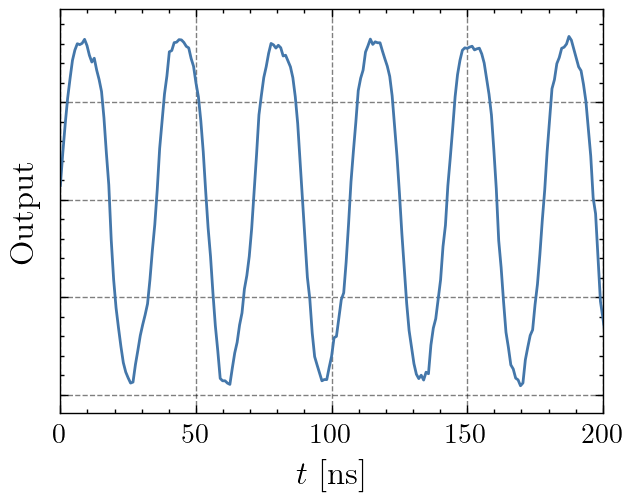

In [304]:
fig, ax = plt.subplots(dpi=200)
ax.plot(t, aligned_cosine_signal)
ax.set_ylabel("Output", fontsize='large')
ax.set_xlabel("$t$ [ns]", fontsize='large')
_ = ax.set_yticklabels("")
ax.set_xlim(0,200)
fig.savefig("plots/freq_manipulation/output_signal_cosine.svg", transparent=True)

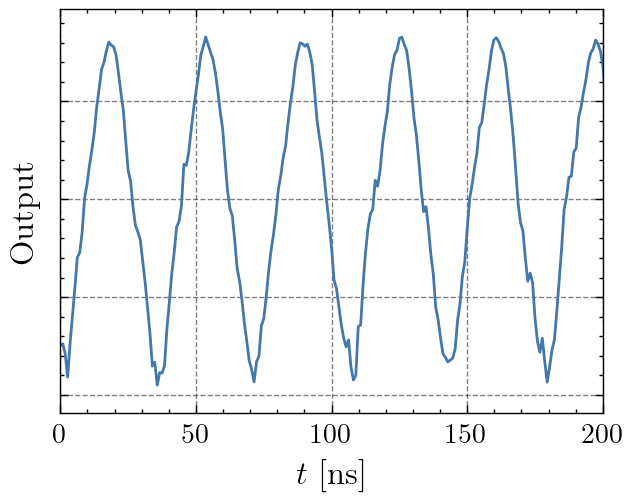

In [305]:
fig, ax = plt.subplots(dpi=200)
ax.plot(t, aligned_triangle_signal)
ax.set_ylabel("Output", fontsize='large')
ax.set_xlabel("$t$ [ns]", fontsize='large')
_ = ax.set_yticklabels("")
ax.set_xlim(0,200)
fig.savefig("plots/freq_manipulation/output_signal_triangle.svg", transparent=True)